# Install required packages

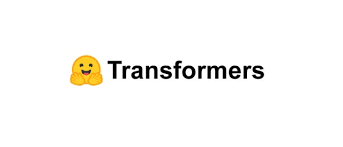

In [1]:
! pip install datasets transformers sacrebleu torch sentencepiece transformers[sentencepiece]

     |████████████████████████████████| 312 kB 5.3 MB/s 
     |████████████████████████████████| 3.8 MB 34.9 MB/s 
     |████████████████████████████████| 90 kB 8.9 MB/s 
     |████████████████████████████████| 1.2 MB 37.5 MB/s 
     |████████████████████████████████| 212 kB 46.6 MB/s 
     |████████████████████████████████| 134 kB 48.3 MB/s 
     |████████████████████████████████| 67 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 41.3 MB/s 
     |████████████████████████████████| 127 kB 48.9 MB/s 
     |████████████████████████████████| 6.5 MB 34.1 MB/s 
     |████████████████████████████████| 596 kB 47.1 MB/s 
     |████████████████████████████████| 895 kB 42.8 MB/s 
     |████████████████████████████████| 144 kB 48.3 MB/s 
     |████████████████████████████████| 271 kB 45.8 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully unins

# Fine-tuning a model on a translation task

In this notebook, we will see how to fine-tune one of the hugging-face Transformers model for a english to romanian translation task. We will use the WMT dataset, a machine translation dataset composed from a collection of various sources, including news commentaries and parliament proceedings.

Below is the example translation text using pre-trained model

Reference : https://huggingface.co/Helsinki-NLP/opus-mt-en-ro


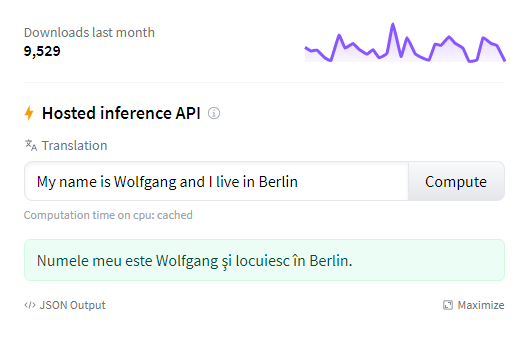

In [2]:
model_checkpoint = "Helsinki-NLP/opus-mt-en-ro"

### Loading the dataset

We will use the [datasets](https://github.com/huggingface/datasets/tree/master/datasets/wmt16) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). We use the English/Romanian part of the WMT dataset here

In [3]:
from datasets import load_dataset, load_metric
raw_datasets = load_dataset("wmt16", "ro-en")
metric = load_metric("sacrebleu")

Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.73k [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/225M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/38.7M [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset wmt16 downloaded and prepared to /root/.cache/huggingface/datasets/wmt16/ro-en/1.0.0/9e0038fe4cc117bd474d2774032cc133e355146ed0a47021b2040ca9db4645c0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.36k [00:00<?, ?B/s]

In [4]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 610320
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1999
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1999
    })
})

In [6]:
raw_datasets["train"][1]

{'translation': {'en': 'Approval of Minutes of previous sitting: see Minutes',
  'ro': 'Aprobarea procesului-verbal al şedinţei precedente: a se vedea procesul-verbal'}}

To get a sense of how the data looks like, the following function will show some examples picked randomly in the dataset.

In [8]:
metric

Metric(name: "sacrebleu", features: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}, usage: """
Produces BLEU scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions: The system stream (a sequence of segments).
    references: A list of one or more reference streams (each a sequence of segments).
    smooth_method: The smoothing method to use. (Default: 'exp').
    smooth_value: The smoothing value. Only valid for 'floor' and 'add-k'. (Defaults: floor: 0.1, add-k: 1).
    tokenize: Tokenization method to use for BLEU. If not provided, defaults to 'zh' for Chinese, 'ja-mecab' for
        Japanese and '13a' (mteval) otherwise.
    lowercase: Lowercase the data. If True, enables case-insensitivity. (Default: False).
    force: Insist that your tokenized input is actually detokenized.

Returns:
    'score': BLEU score,
    'counts'

You can call its compute method with your predictions and labels, which need to be list of decoded strings (list of list for the labels):

BLEU (BiLingual Evaluation Understudy) is a metric for automatically evaluating machine-translated text. The BLEU score is a number between zero and one that measures the similarity of the machine-translated text to a set of high quality reference translations

In [9]:
fake_preds = ["hello there", "general kenobi"]
fake_labels = [["hello there"], ["general kenobi"]]
metric.compute(predictions=fake_preds, references=fake_labels)

{'bp': 1.0,
 'counts': [4, 2, 0, 0],
 'precisions': [100.0, 100.0, 0.0, 0.0],
 'ref_len': 4,
 'score': 0.0,
 'sys_len': 4,
 'totals': [4, 2, 0, 0]}

# Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a Transformers Tokenizer which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the AutoTokenizer.from_pretrained method, which will ensure:

we get a tokenizer that corresponds to the model architecture we want to use,
we download the vocabulary used when pretraining this specific checkpoint.




In [10]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/770k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

You can directly call this tokenizer on one sentence or a pair of sentences:

In [11]:
tokenizer(["Hello, how are you!", "I am fine"])

{'input_ids': [[125, 778, 3, 63, 141, 9191, 23, 0], [187, 32, 716, 9191, 2, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

We can then write the function that will preprocess our samples. We just feed them to the tokenizer with the argument truncation=True. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model. The padding will be dealt with later on (in a data collator) so we pad examples to the longest length in the batch and not the whole dataset.

In [12]:
prefix = ""
max_input_length = 128
max_target_length = 128
source_lang = "en"
target_lang = "ro"
def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)
    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [13]:
preprocess_function(raw_datasets['train'][:2])

{'input_ids': [[393, 4462, 14, 1137, 53, 216, 28636, 0], [24385, 14, 28636, 14, 4646, 4622, 53, 216, 28636, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[42140, 494, 1750, 53, 8, 59, 903, 3543, 9, 15202, 0], [36199, 6612, 9, 15202, 122, 568, 35788, 21549, 53, 8, 59, 903, 3543, 9, 15202, 0]]}

To apply this function on all the pairs of sentences in our dataset, we just use the map method of our dataset object we created earlier. This will apply the function on all the elements of all the splits in dataset, so our training, validation and testing data will be preprocessed in one single command

In [14]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

  0%|          | 0/611 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since our task is of the sequence-to-sequence kind, we use the AutoModelForSeq2SeqLM class. Like with the tokenizer, the from_pretrained method will download and cache the model for us.

In [15]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/287M [00:00<?, ?B/s]

To instantiate a Seq2SeqTrainer, we will need to define three more things. The most important is the [Seq2SeqTrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [16]:
batch_size = 16
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True    
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the batch_size defined at the top of the cell and customize the weight decay. Since the Seq2SeqTrainer will save the model regularly and our dataset is quite large, we tell it to make three saves maximum. Lastly, we use the predict_with_generate option (to properly generate summaries) and activate mixed precision training (to go a bit faster).

Model will save under **{model_name}-finetuned-{source_lang}-to-{target_lang}** directory

Then, we need a special kind of data collator, which will not only pad the inputs to the maximum length in the batch, but also the labels:

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

The last thing to define for our Seq2SeqTrainer is how to compute the metrics from the predictions. We need to define a function for this, which will just use the metric we loaded earlier, and we have to do a bit of pre-processing to decode the predictions into texts:

In [19]:
import numpy as np
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]
    return preds, labels
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

Then we just need to pass all of this along with our datasets to the Seq2SeqTrainer:

In [22]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

We can now finetune our model by just calling the train method:

In [23]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `MarianMTModel.forward` and have been ignored: translation. If translation are not expected by `MarianMTModel.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 610320
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 38145


Epoch,Training Loss,Validation Loss


Saving model checkpoint to opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500
Configuration saved in opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/config.json
Model weights saved in opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/pytorch_model.bin
tokenizer config file saved in opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/tokenizer_config.json
Special tokens file saved in opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/special_tokens_map.json


KeyboardInterrupt: ignored

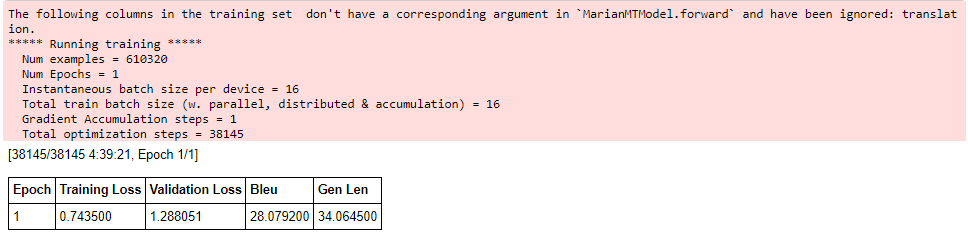

In [24]:
import os
for dirname, _, filenames in os.walk('opus-mt-en-ro-finetuned-en-to-ro'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

opus-mt-en-ro-finetuned-en-to-ro/runs/Mar08_15-03-42_5aed06417691/events.out.tfevents.1646752087.5aed06417691.76.0
opus-mt-en-ro-finetuned-en-to-ro/runs/Mar08_15-03-42_5aed06417691/1646752087.2719686/events.out.tfevents.1646752087.5aed06417691.76.1
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/rng_state.pth
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/special_tokens_map.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/vocab.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/source.spm
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/optimizer.pt
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/config.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/tokenizer_config.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/scheduler.pt
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/pytorch_model.bin
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/target.spm
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/trainer_state.json
opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/trainin

Our fine tuned model already saved under *opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500*

Load the model and translate some text from english to romanian

In [25]:
from transformers import MarianMTModel, MarianTokenizer
src_text = ['Welcome to the session. My name is sanjay']

model_name = 'opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500'
tokenizer = MarianTokenizer.from_pretrained(model_name)
print(tokenizer.supported_language_codes)


Didn't find file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/added_tokens.json. We won't load it.
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/source.spm
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/target.spm
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/vocab.json
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/tokenizer_config.json
loading file None
loading file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/special_tokens_map.json


[]


In [26]:
model = MarianMTModel.from_pretrained(model_name)
translated = model.generate(**tokenizer(src_text, return_tensors="pt", padding=True))
[tokenizer.decode(t, skip_special_tokens=True) for t in translated]

loading configuration file opus-mt-en-ro-finetuned-en-to-ro/checkpoint-500/config.json
Model config MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-en-ro",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      59542
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 59542,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "L

['Bine aţi venit la şedinţă, numele meu este Sanjay.']